{
  "node_id": "15eced5e-60cf-45e5-9216-0931e8015b81",
  "shape": [
    20,
    30,
    4
  ],
  "name": "result",
  "dtype": "torch.float16"
}


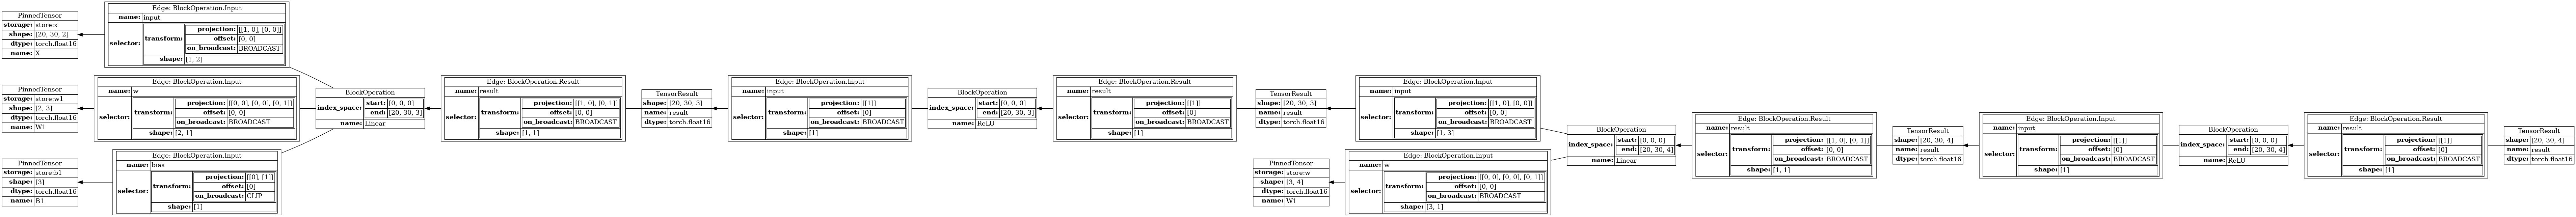

In [3]:
from tapestry.jupyter_utils import display_graph
from typing import Optional

import numpy as np
import torch

from tapestry.expression_graph import (
    BlockOperation,
    PinnedTensor,
    TapestryGraph,
    TensorResult,
    TensorValue,
)
from tapestry.zspace import BroadcastMode, ZRange, ZRangeMap, ZTransform, assert_shape


def _name_and_shape(val: TensorValue):
    s = "Tensor"
    if val.name:
        s += f"[{val.name}]"
    s += f"{val.shape}"
    return s


def linear_op(
    *,
    x: TensorValue,
    w: TensorValue,
    bias: Optional[TensorValue] = None,
) -> TensorResult:
    graph = x.assert_graph()
    assert w.graph == graph

    assert len(w.shape) == 2, w.shape
    in_dim = w.shape[0]
    out_dim = w.shape[1]

    assert_shape(
        x.shape[-1:],
        w.shape[:1],
        "input shape {xshape} in_dim {actual} incompatible "
        "with weight shape {wshape} in_dim {expected}",
        xshape=x.shape,
        wshape=w.shape,
    )

    index_space = ZRange(x.shape[:-1].tolist() + [out_dim])

    op_name = "Linear"

    op = graph.add_node(
        BlockOperation(
            name=op_name,
            index_space=index_space,
        )
    )

    op.bind_tiled_input(
        name="input",
        value=x,
        projection=[[1, 0], [0, 0]],
        shape=[1, in_dim],
    )

    projection = np.zeros((index_space.ndim, 2))
    projection[-1, -1] = 1

    op.bind_tiled_input(
        name="w",
        value=w,
        projection=projection,
        shape=[in_dim, 1],
    )

    if bias is not None:
        assert_shape(
            bias.shape,
            w.shape[-1:],
            "bias shape {actual} != weight [out_dim] {expected}",
        )

        op.bind_tiled_input(
            name="bias",
            value=bias,
            projection=[[0], [1]],
            shape=[1],
            on_broadcast=BroadcastMode.CLIP,
        )

    return op.bind_result(
        name="result",
        selector=ZRangeMap(
            transform=ZTransform(
                projection=[[1, 0], [0, 1]],
                on_broadcast=BroadcastMode.BROADCAST,
            ),
            shape=[1, 1],
        ),
    )


def relu_op(
    value: TensorValue,
) -> TensorResult:
    graph = value.assert_graph()

    index_space = ZRange(value.shape)

    op_name = "ReLU"

    op = graph.add_node(
        BlockOperation(
            name=op_name,
            index_space=index_space,
        )
    )

    selector = ZRangeMap.identity_map()

    op.bind_input(
        name="input",
        value=value,
        selector=selector,
    )

    return op.bind_result(
        name="result",
        selector=selector,
    )


g = TapestryGraph()

x = g.add_node(
    PinnedTensor(
        name="X",
        shape=[20, 30, 2],
        dtype=torch.float16,
        storage="store:x",
    )
)

w1 = g.add_node(
    PinnedTensor(
        name="W1",
        shape=[2, 3],
        dtype=torch.float16,
        storage="store:w1",
    )
)

b1 = g.add_node(
    PinnedTensor(
        name="B1",
        shape=[3],
        dtype=torch.float16,
        storage="store:b1",
    )
)

a = linear_op(x=x, w=w1, bias=b1)

y = relu_op(a)

w2 = g.add_node(
    PinnedTensor(
        name="W1",
        shape=[3, 4],
        dtype=torch.float16,
        storage="store:w",
    )
)

z = relu_op(linear_op(x=y, w=w2))
print(z.pretty())

g.mark_observed(a)
g.mark_observed(z)

g.validate()

display_graph(g)